In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [1]:
eval_dir = "/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/"

In [11]:
# categorization function
def event_cat( row, no_gc_row=None ):
    event = row["event"]
    # if gc stop, we find the event w/o gc, if provided
    if no_gc_row is not None and ( event.startswith("gc_minor_stop") or event.startswith("gc_major_stop") ):
        return event_cat( no_gc_row )
    elif event.startswith("gc_minor_start") or event.startswith("gc_major_start"):
        return "gc"
    elif event.startswith("tracing_start"):
        return "tracing"
    elif event.startswith("blackhole_start") or event.startswith("blackhole_stop_leave"):
        return "blackhole"
    elif event.startswith("jit") or event.startswith("finish") or event.startswith("fun_return"):
        return "jit"
    elif event.startswith("fun_call"):
        return "fun"
    return "other"

In [14]:
def activity_plot_from_csv( csv_file, return_raw=False, max_cycle=0, extra_stats=[] ):
    # load the csv file
    raw = pd.read_csv( csv_file )
    raw['insts_diff'] = raw.insts.diff()
    raw['cycles_diff'] = raw.cycles.diff()
    raw['ipc'] = raw['insts_diff'] / raw['cycles_diff']
    
    raw = raw.set_index("insts", drop=False)
    # add an event so that we start with other
    raw = pd.DataFrame( [["foo"]], columns=["event"], index=[0] ).append( raw )

    raw_no_gc = raw[ raw["event"].map( lambda x: not x.startswith("gc") ) ]
    
    # find max cycle
    if max_cycle == 0:
        max_cycle = raw.index[-1]
    num_points = 10000
    quant = max_cycle/num_points
    plot_df = pd.DataFrame( [i*quant for i in range(num_points)], columns=["insts"] )
    # generate another df for more averaged results
    num_points = 500
    quant = max_cycle/num_points
    plot_df2 = pd.DataFrame( [i*quant for i in range(num_points)], columns=["insts"] )
    # we use searchsorted - 1 to find the last activated event. this is an issue in gc, where different events might
    # have triggered it. so we pass both w/ gc and w/o gc closest find, and pick the w/o gc even in case the last find
    # was gc stop
    plot_df["event"] = plot_df.apply( lambda x: event_cat(
                            raw.iloc[ raw.index.searchsorted(x["insts"])-1 ],
                            raw_no_gc.iloc[ raw_no_gc.index.searchsorted(x["insts"])-1 ] ), axis=1 )
    event_map = { "other" : 0, "gc" : 1, "tracing": 2, "blackhole": 3, "jit" : 4, "fun" : 5 }
    plot_df["event_id"] = plot_df.apply( lambda x : event_map.get(x["event"]), axis=1 )
    
    plot_df2["cycles"] = plot_df2.apply( lambda x : raw.iloc[ raw.index.searchsorted(x["insts"]) ]["cycles"], axis=1 )
    plot_df2["insts_acc"] = plot_df2.apply( lambda x : raw.iloc[ raw.index.searchsorted(x["insts"]) ]["insts"], axis=1 )
    plot_df2["insts_acc_diff"] = plot_df2.insts_acc.diff()
    plot_df2["cycles_diff"] = plot_df2.cycles.diff()
    plot_df2["ipc"] = plot_df2.insts_acc_diff / plot_df2.cycles_diff
    # loop over the extra stats and generate data
    for stat in extra_stats:
        plot_df2[stat] = plot_df2.apply( lambda x : raw.iloc[ raw.index.searchsorted(x["insts"]) ][stat], axis=1 )
        plot_df2[stat+"_diff"] = plot_df2[stat].diff()
        plot_df2[stat+"_pi"] = plot_df2[stat+"_diff"] / plot_df2.insts_acc_diff
    
    plot_df2 = plot_df2.dropna()
    #return plot_df2
    
    num_extra = len(extra_stats)
    fig, axes = plt.subplots(2+num_extra, 1, figsize=[15,6+(3*num_extra)], sharex=True)
    
    # hacky: set the category types here. plot also tries to plot -1 as well, so we use an empty string to ensure
    # things work out
    axes[0].set_yticklabels( [ "", "other", "gc", "tracing", "blackhole", "jit", "jitfun"] )
    # hacky: use vertical line scatter plot and stretch it (grow 700 times, make line width very narrow)
    plot_df.plot( kind="scatter", x="insts", y="event_id", c='black', ylim=[-0.5, 5.5], xlim=0, marker='|', s=500, lw=0.1, ax=axes[0] )
    plot_df2.plot(  x="insts", y="ipc", c="blue", ax=axes[1] )
    axis_idx = 2
    for stat in extra_stats:
        plot_df2.plot(  x="insts", y=stat+"_pi", c="blue", ax=axes[axis_idx] )
        axis_idx += 1
    
    if return_raw:
        return raw

In [5]:
def find_event( raw_df, start_insts, len_insts, event="blackhole_stop_exc" ):
    # filter out all the events and just leave the event we're looking for
    raw_df = raw_df.query( "event == @event" )
    # assign the iter field
    raw_df["iter"] = xrange( 1, raw_df.shape[0]+1 )
    # start iterating from the first match
    row = raw_df.iloc[ raw_df.index.searchsorted( start_insts ) ]
    start_threshold = ( row.insts, row.iter )
    row = raw_df.iloc[ raw_df.index.searchsorted( row.insts + len_insts ) ]
    end_threshold = ( row.insts, row.iter )
            
    return start_threshold, end_threshold

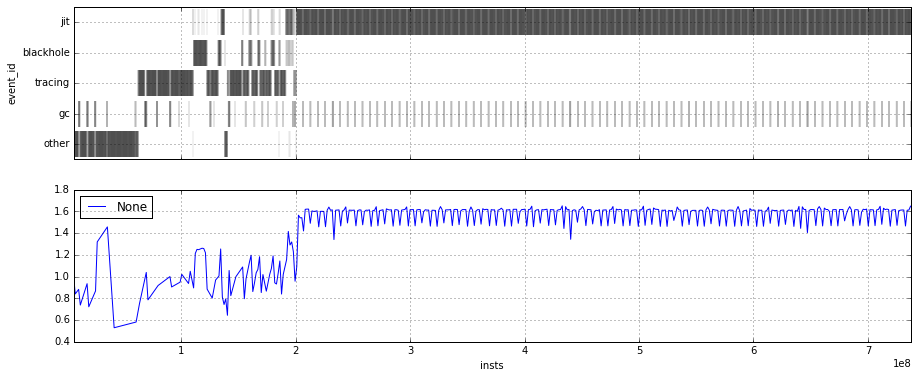

In [95]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_vvadd_altjit_ubmark_simple/event_file.csv")

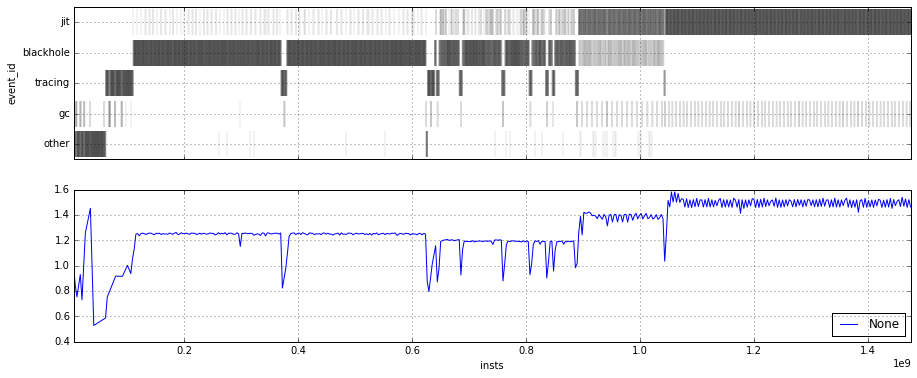

In [94]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_vvadd_ubmark_simple/event_file.csv")

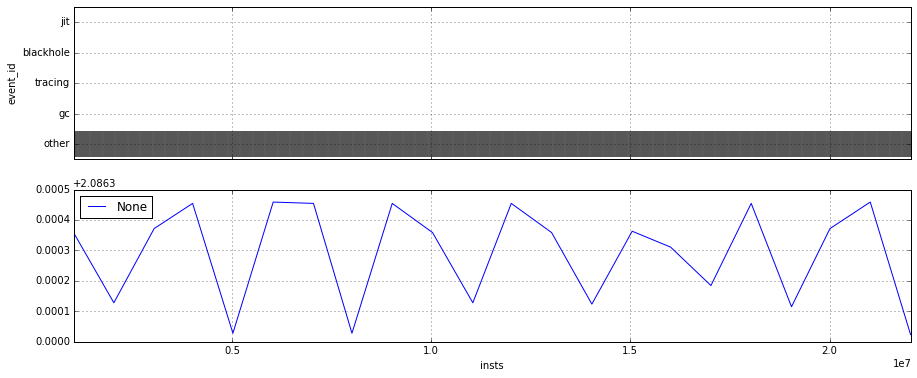

In [112]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/vvadd-arm_native/event_file.csv")

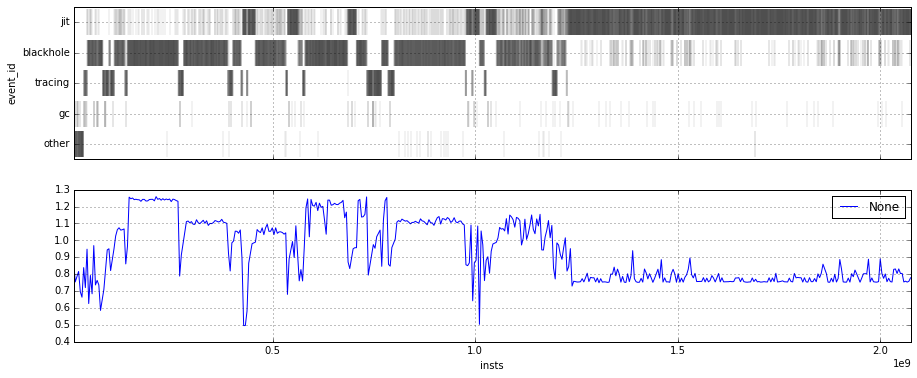

In [111]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_bm_ai_mini_simple/event_file.csv")

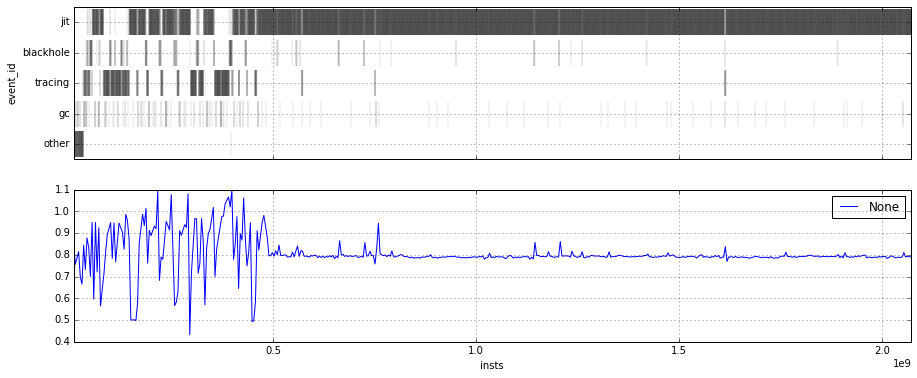

In [110]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_bm_ai_mini_altjit_simple/event_file.csv")

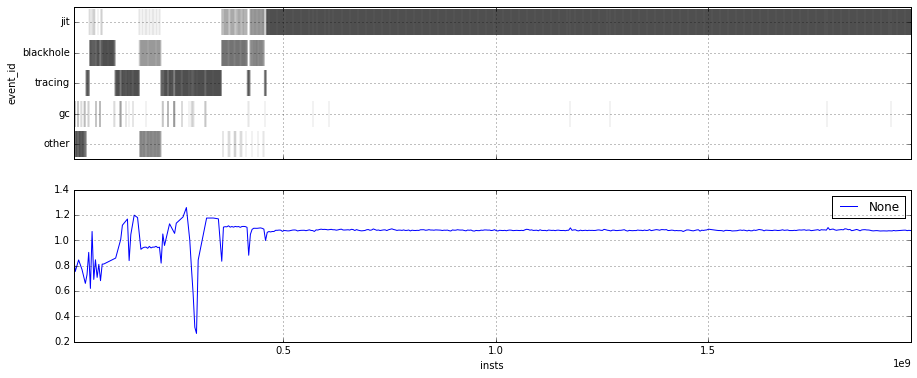

In [109]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_bm_nbody_mini_simple/event_file.csv")

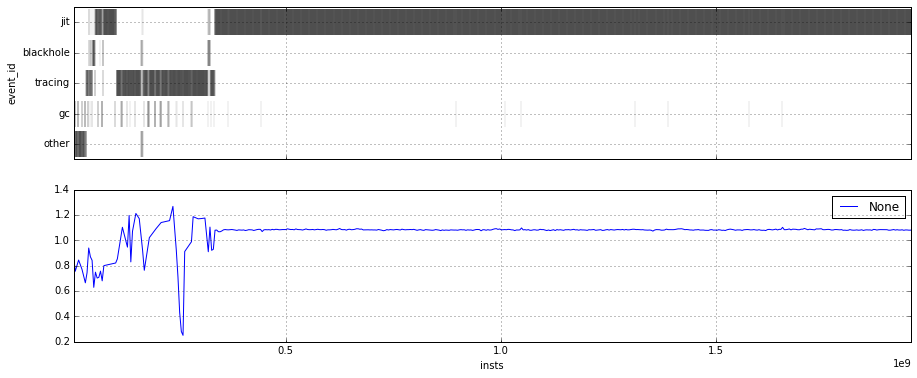

In [108]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_bm_nbody_mini_altjit_simple/event_file.csv")

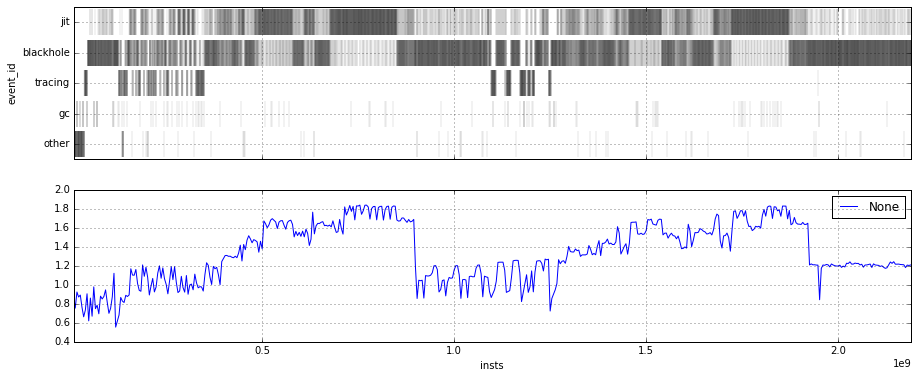

In [107]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_bm_regex_effbot_mini_simple/event_file.csv")

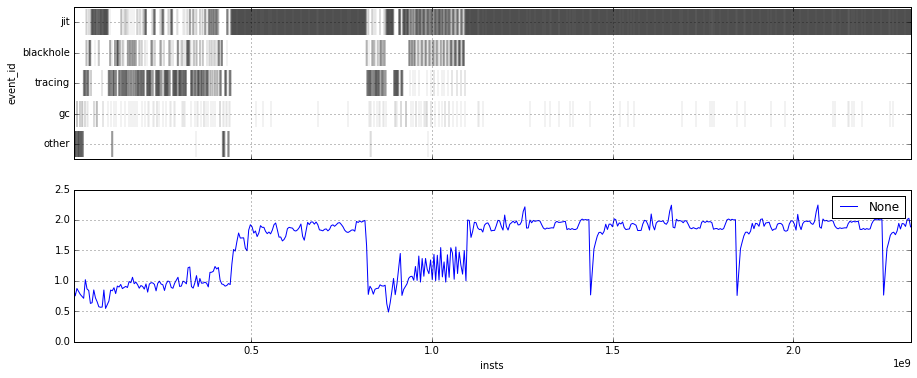

In [106]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_bm_regex_effbot_mini_altjit_simple/event_file.csv")

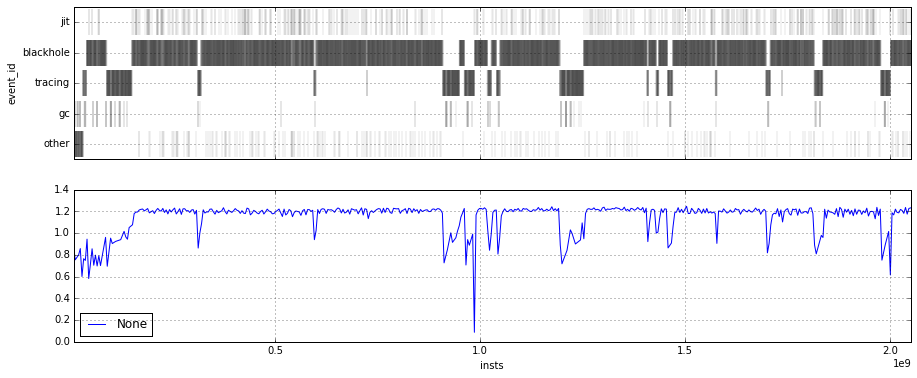

In [104]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_bm_richards_mini_simple/event_file.csv")

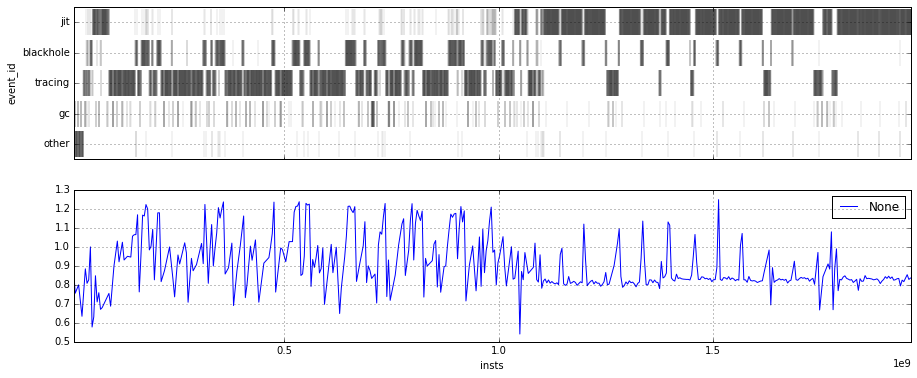

In [105]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/cyc_bm_richards_mini_altjit_simple/event_file.csv")

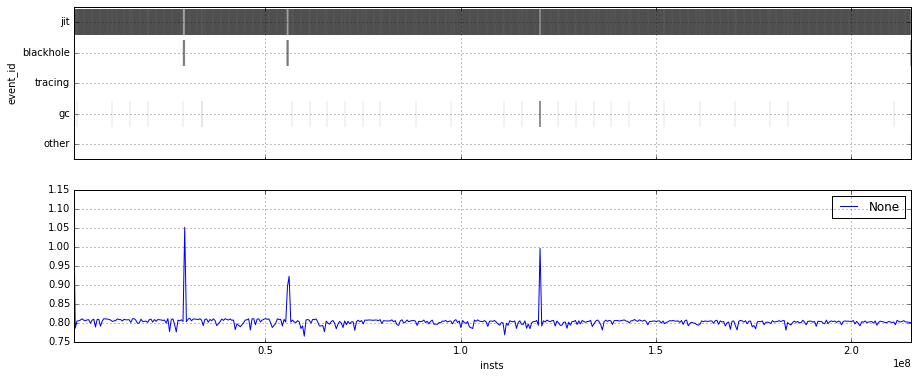

In [113]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_ai_mini_altjit_simple_ff2/event_file.csv")

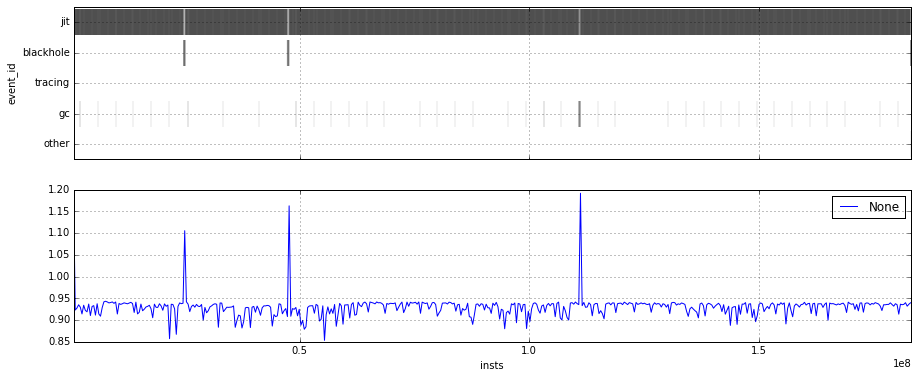

In [114]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_ai_mini_altjit_simple_omit_ff2/event_file.csv")

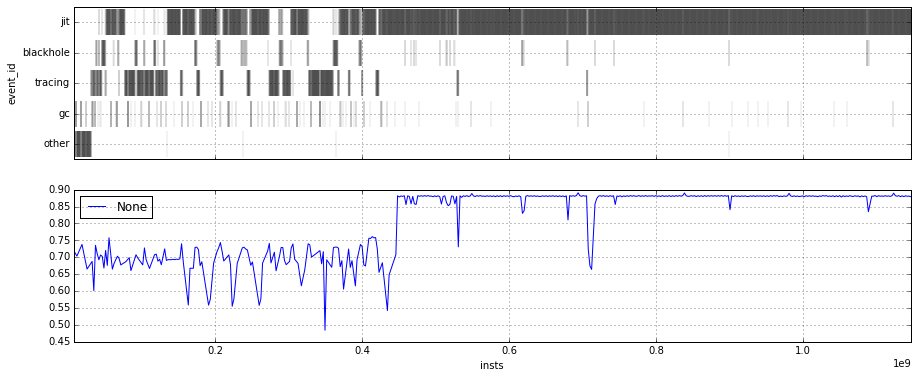

In [115]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_ai_mini_altjit_simple_ff2/event_file_warmup.csv")

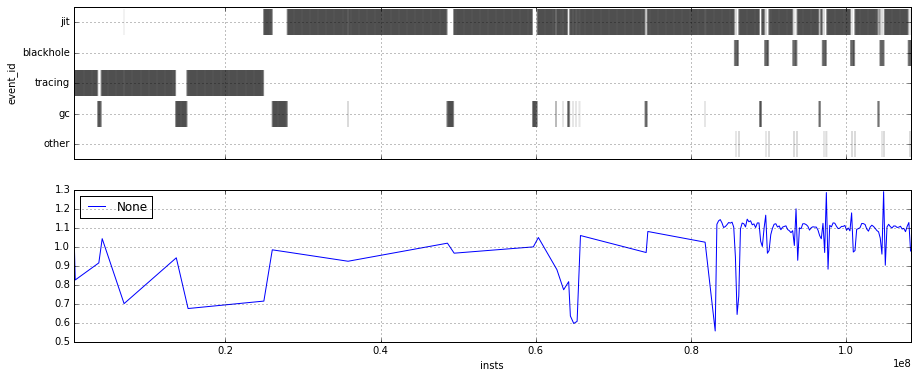

In [167]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/omit2_bm_pickle_mini_altjit_simple_ff2/event_file.csv")

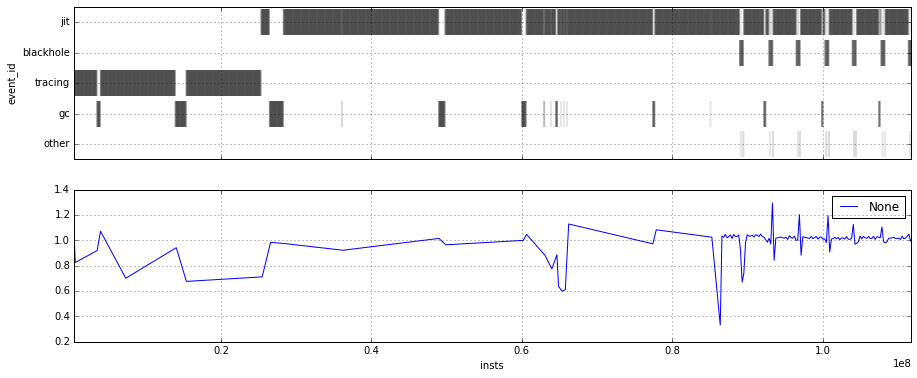

In [168]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/omit2_bm_pickle_mini_altjit_simple_omit_ff2/event_file.csv")

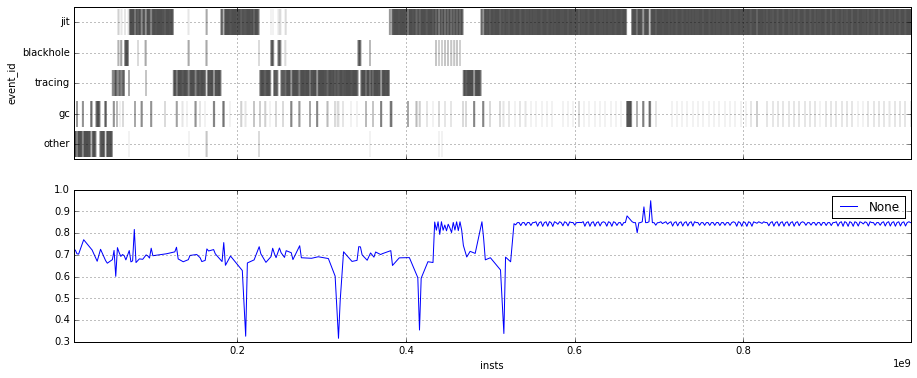

In [166]:
raw = activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_pickle_mini_altjit_simple_ff/event_file_warmup.csv", True, max_cycle=1e9)

In [164]:
find_event( raw, 0.35e9, 1e8 ) 

/home/graduate/bi45/venvs/python2.7.9/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


((357214359.0, 82), (457514374.0, 99))

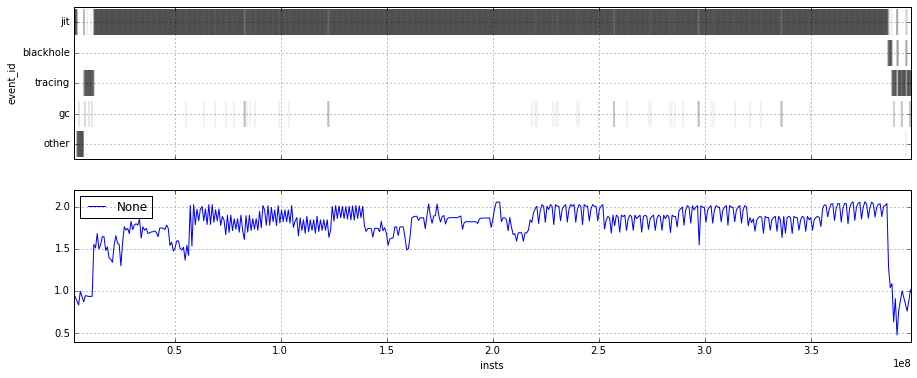

In [119]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_regex_effbot_mini_altjit_simple_ff2/event_file.csv")

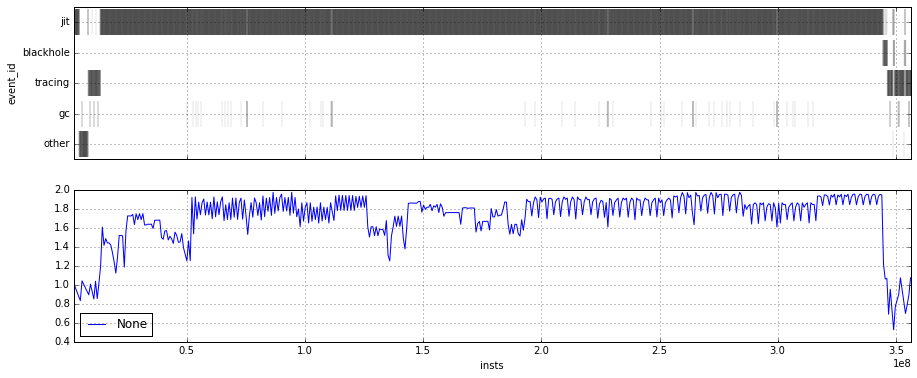

In [120]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_regex_effbot_mini_altjit_simple_omit_ff2/event_file.csv")

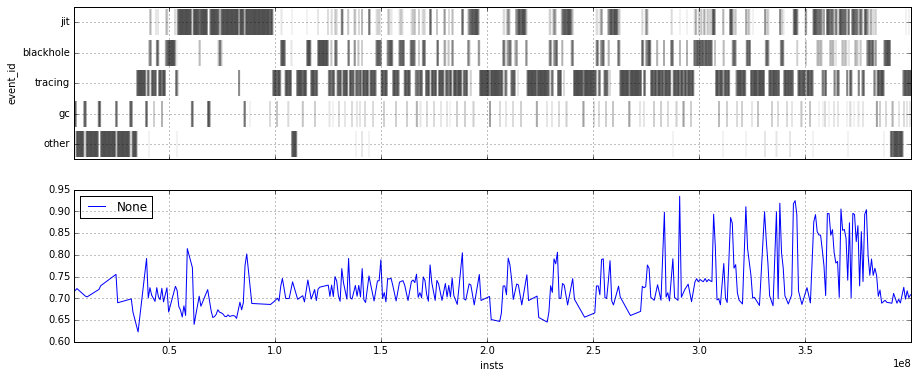

In [121]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_regex_effbot_mini_altjit_simple_ff2/event_file_warmup.csv")

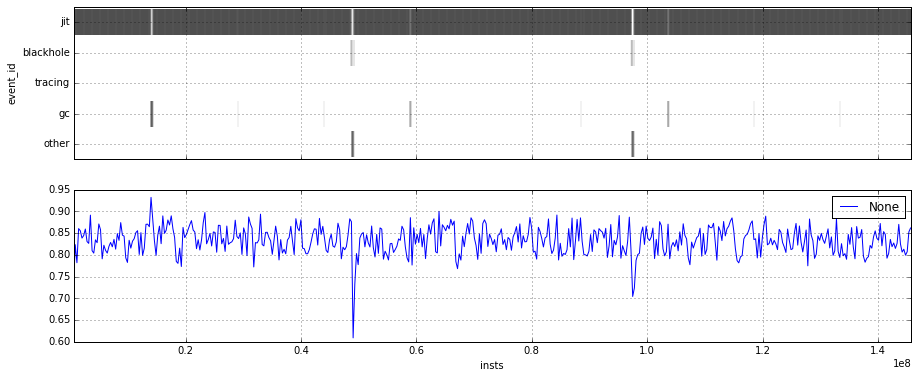

In [122]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_richards_mini_altjit_simple_ff2/event_file.csv")

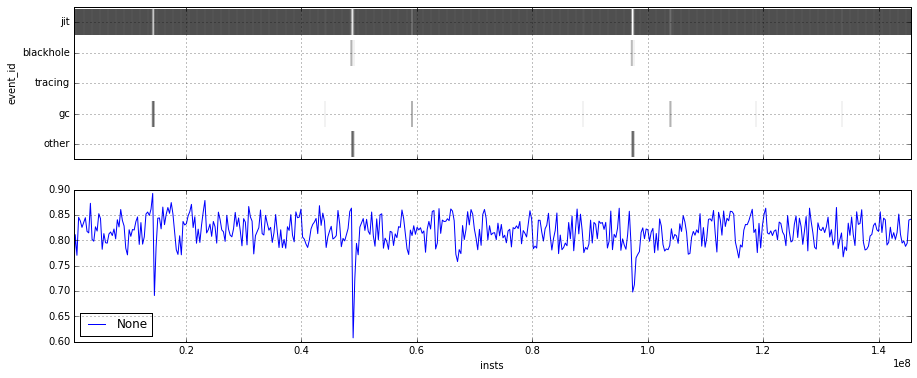

In [123]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_richards_mini_altjit_simple_omit_ff2/event_file.csv")

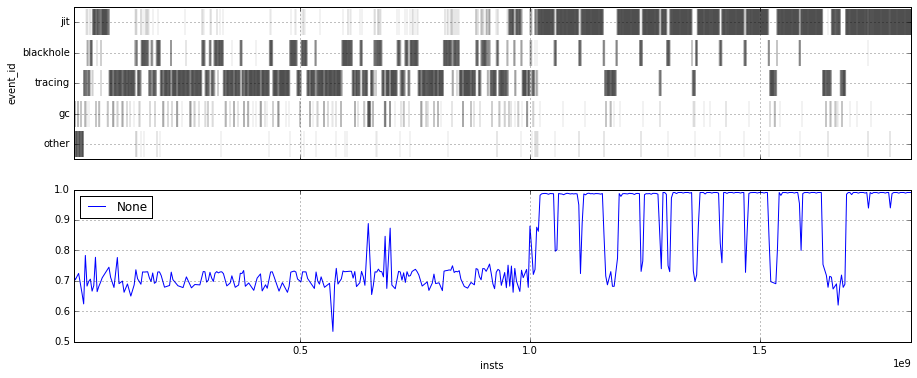

In [124]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/bm_richards_mini_altjit_simple_ff2/event_file_warmup.csv")

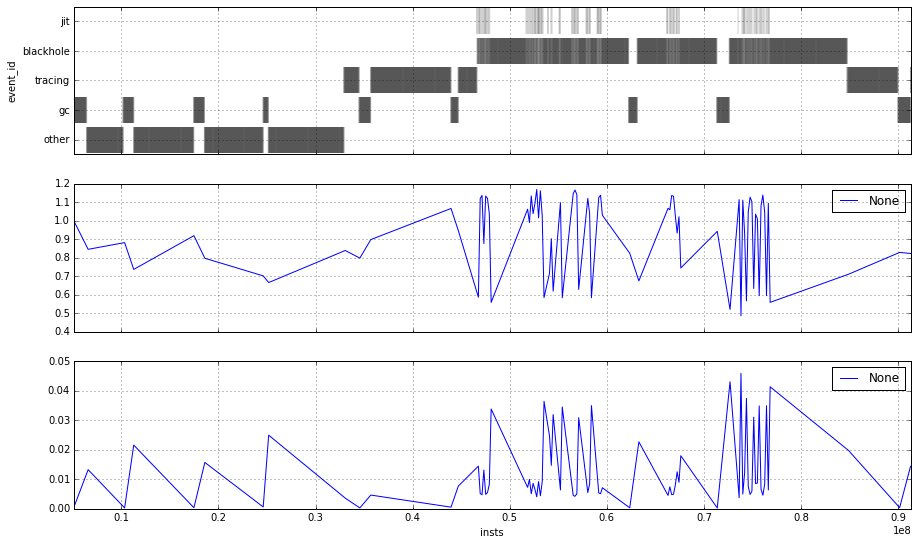

In [173]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/icache_bm_ai_mini_simple_mi_stat/event_file.csv", extra_stats=["system.cpu.icache.overall_misses"])

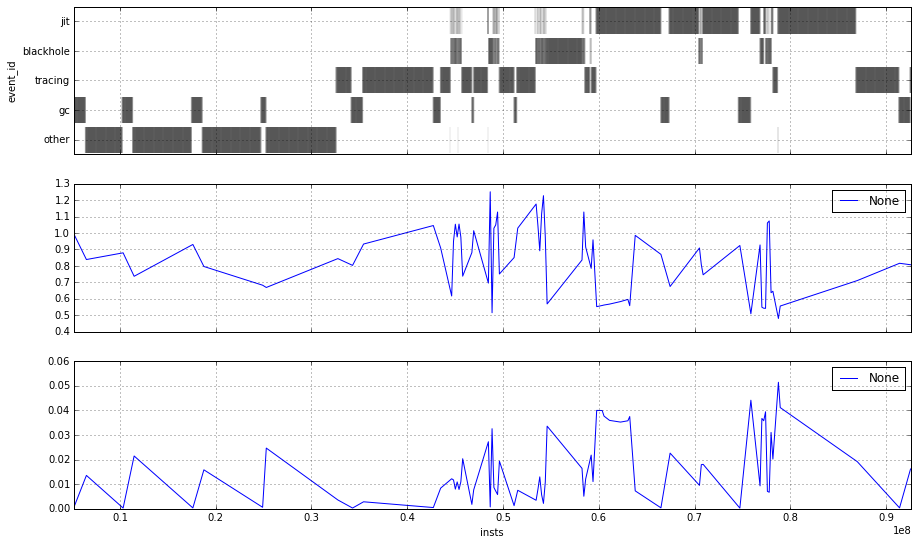

In [176]:
activity_plot_from_csv("/work/bits0/bi45/vc/git-brg/gem5-mcpat/eval/pyxcel/icache_bm_ai_mini_altjit_simple_mi_stat/event_file.csv", extra_stats=["system.cpu.icache.overall_misses"])

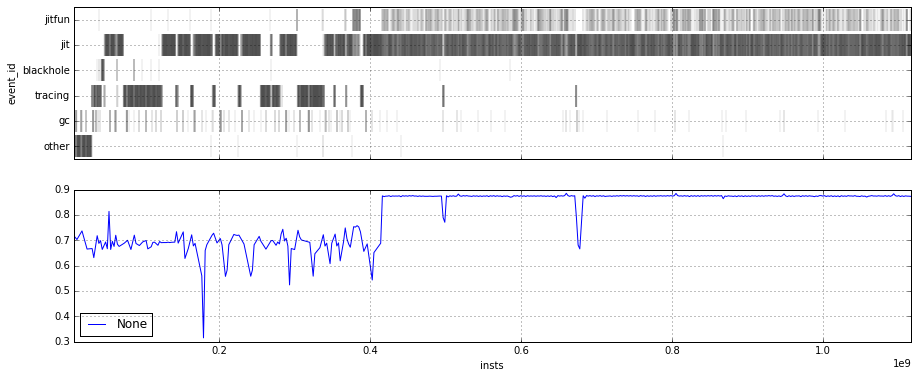

In [15]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_ai_mini_altjit_simple_ff2/event_file_warmup.csv" )

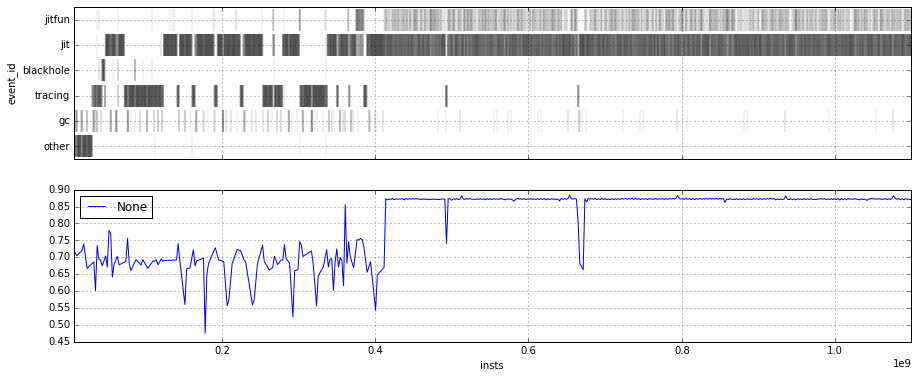

In [38]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/isatest_bm_ai_mini_altjit_simple_force_armv7_ff2_/event_file_warmup.csv" )

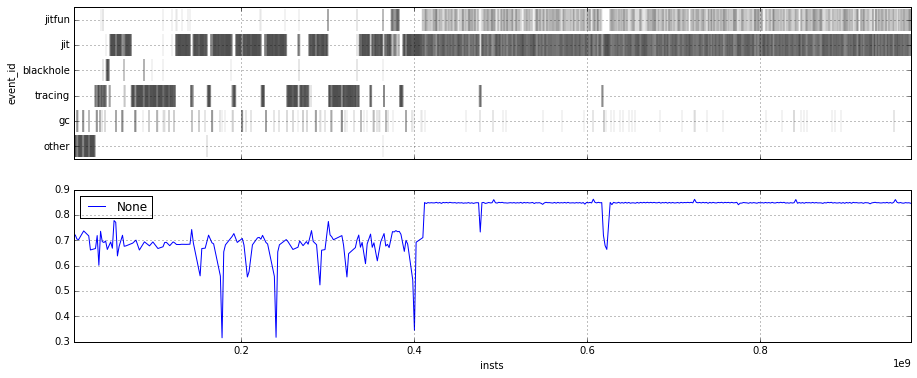

In [16]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_ai_mini_altjit_simple_no_ll_hooks_ff2/event_file_warmup.csv" )

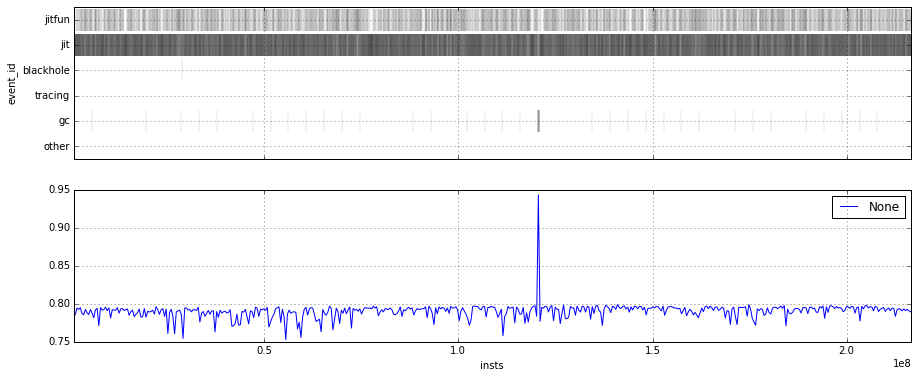

In [17]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_ai_mini_altjit_simple_ff2/event_file.csv" )

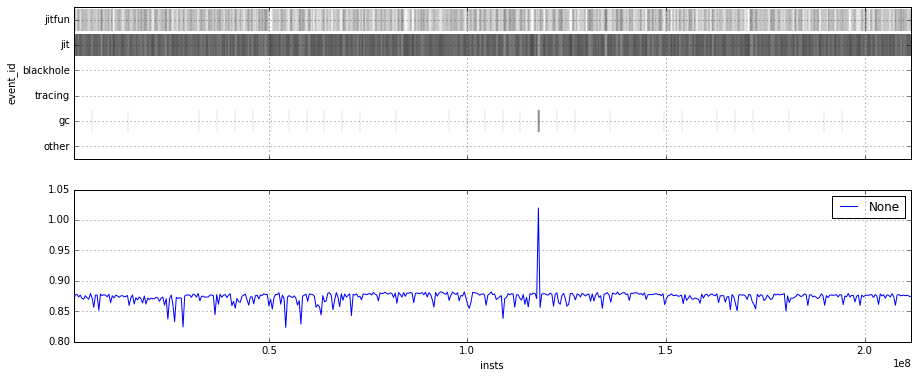

In [39]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/isatest_bm_ai_mini_altjit_simple_force_armv7_ff2_/event_file.csv" )

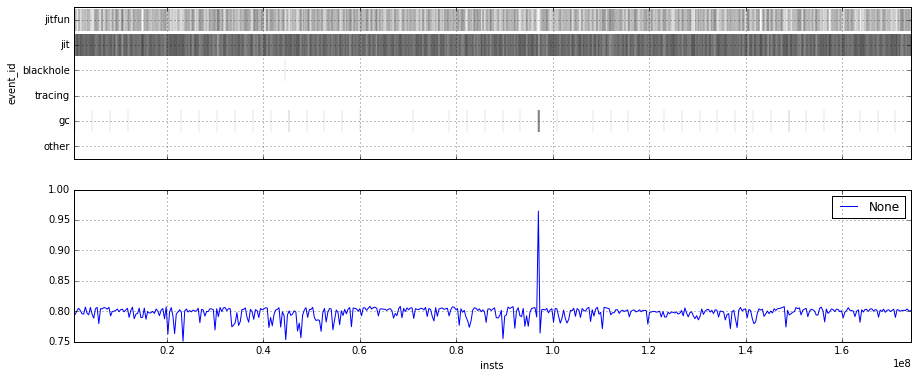

In [19]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_ai_mini_altjit_simple_no_ll_hooks_ff2/event_file.csv" )

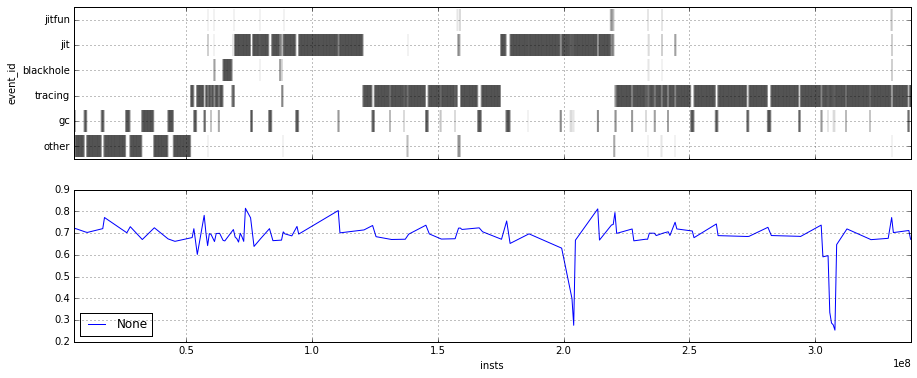

In [20]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_pickle_mini_altjit_simple_ff2/event_file_warmup.csv" )

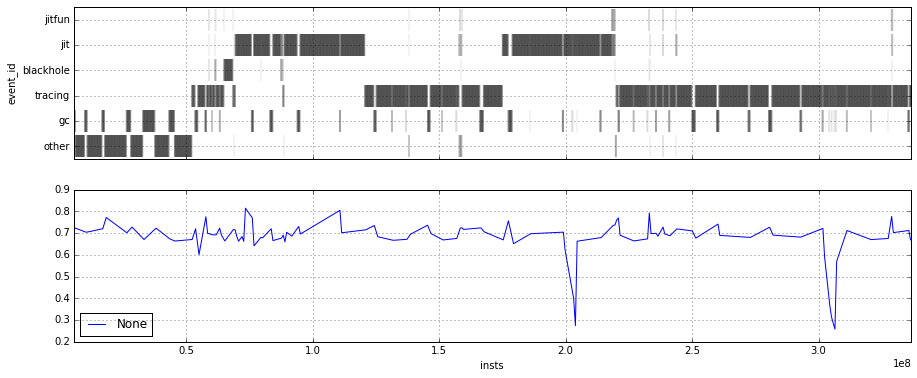

In [40]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/isatest_bm_pickle_mini_altjit_simple_force_armv7_ff2_/event_file_warmup.csv" )

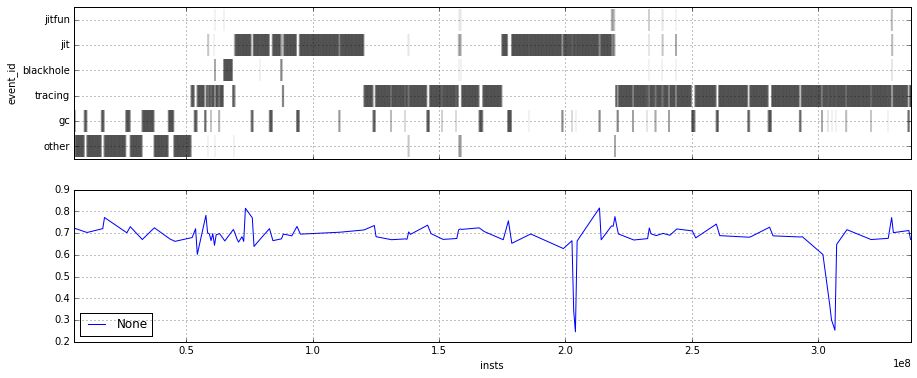

In [22]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_pickle_mini_altjit_simple_no_ll_hooks_ff2/event_file_warmup.csv" )

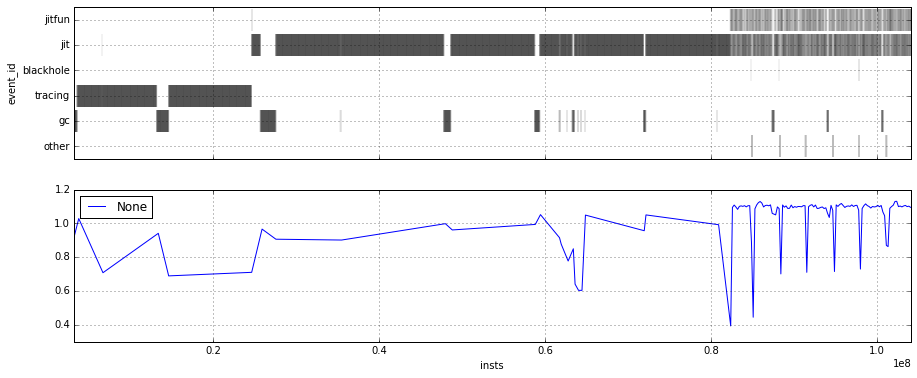

In [24]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_pickle_mini_altjit_simple_ff2/event_file.csv" )

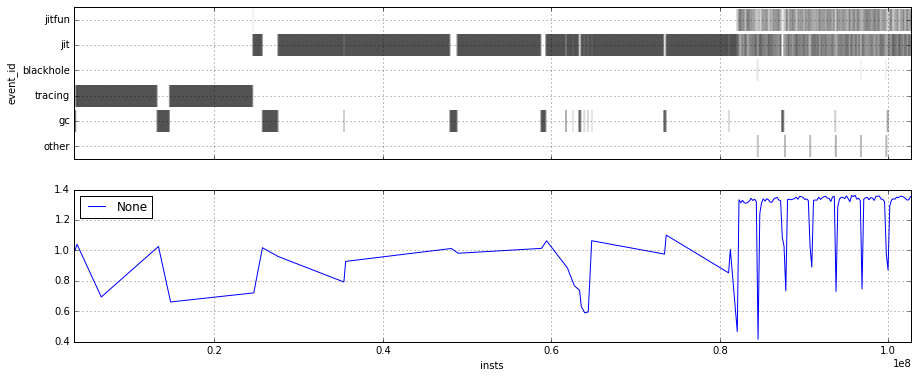

In [41]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/isatest_bm_pickle_mini_altjit_simple_force_armv7_ff2_/event_file.csv" )

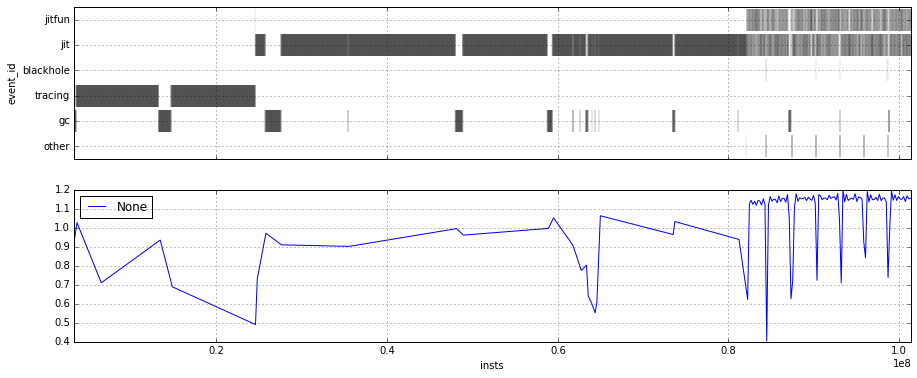

In [26]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_pickle_mini_altjit_simple_no_ll_hooks_ff2/event_file.csv" )

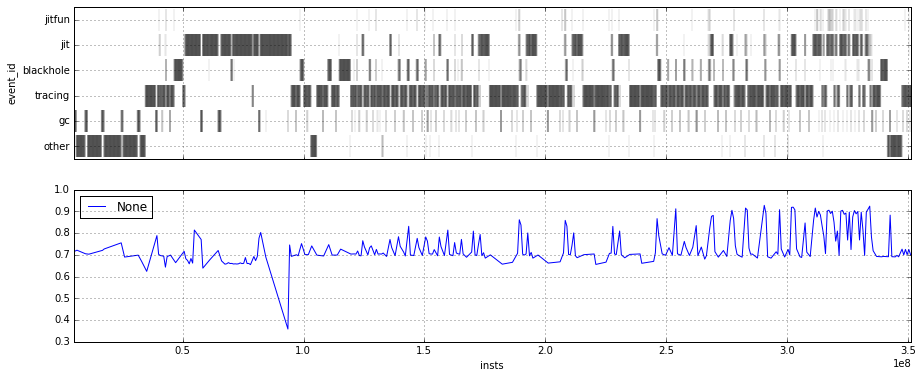

In [27]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_regex_effbot_mini_altjit_simple_ff2/event_file_warmup.csv" )

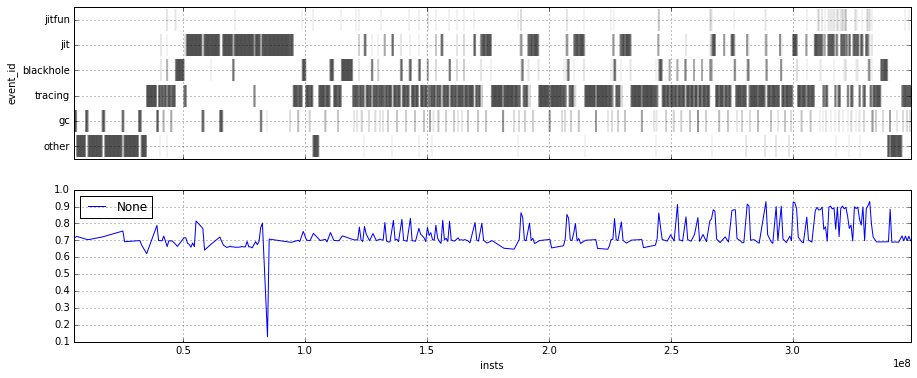

In [42]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/isatest_bm_regex_effbot_mini_altjit_simple_force_armv7_ff2_/event_file_warmup.csv" )

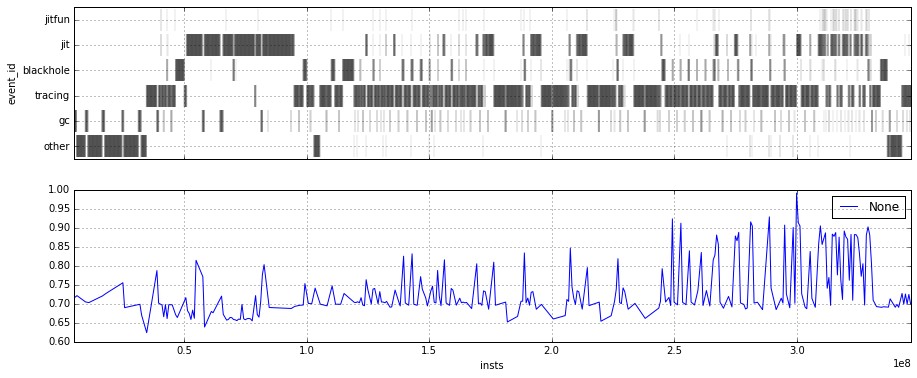

In [28]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_regex_effbot_mini_altjit_simple_no_ll_hooks_ff2/event_file_warmup.csv" )

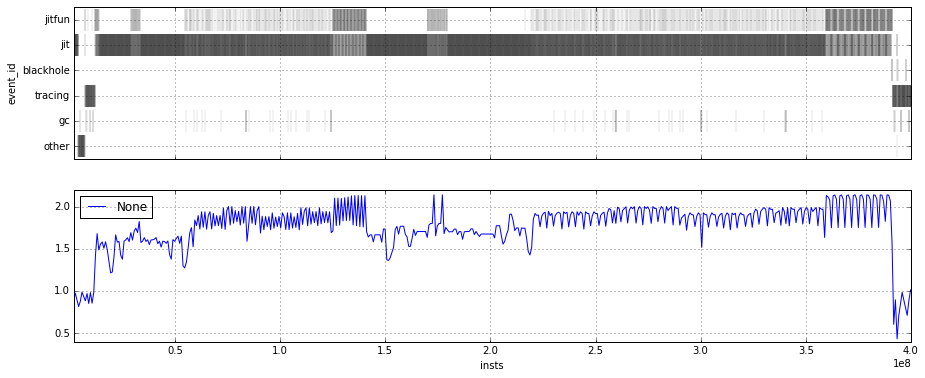

In [31]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_regex_effbot_mini_altjit_simple_ff2/event_file.csv" )

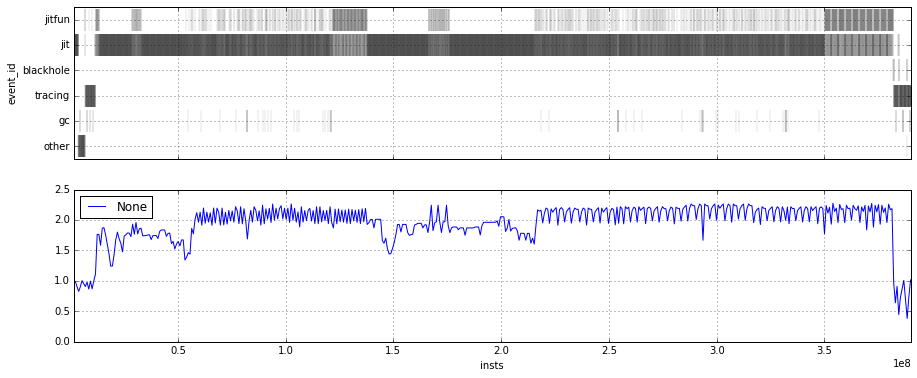

In [43]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/isatest_bm_regex_effbot_mini_altjit_simple_force_armv7_ff2_/event_file.csv" )

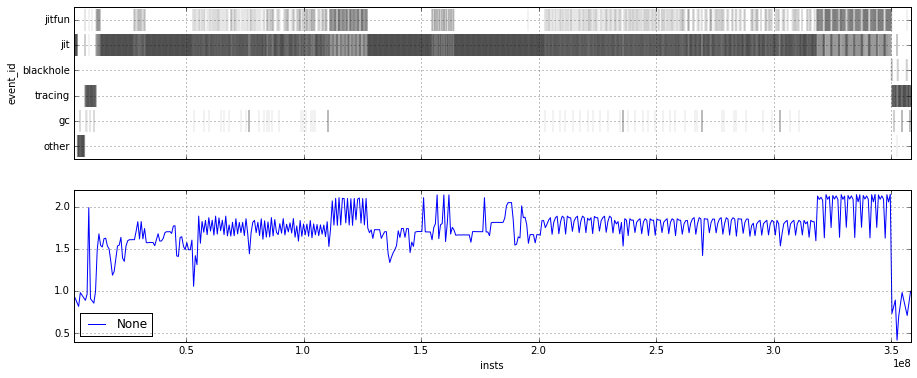

In [30]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_regex_effbot_mini_altjit_simple_no_ll_hooks_ff2/event_file.csv" )

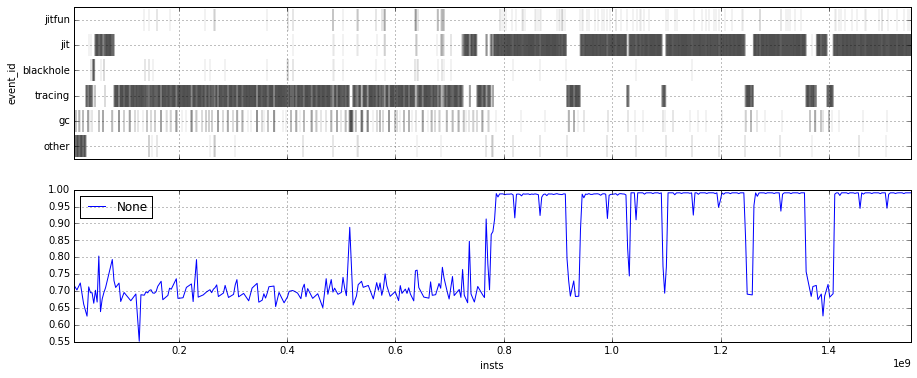

In [32]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_richards_mini_altjit_simple_ff2/event_file_warmup.csv" )

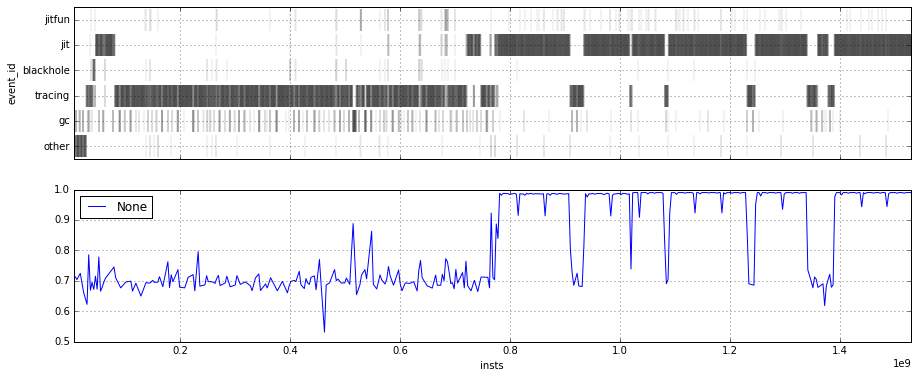

In [44]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/isatest_bm_richards_mini_altjit_simple_force_armv7_ff2_/event_file_warmup.csv" )

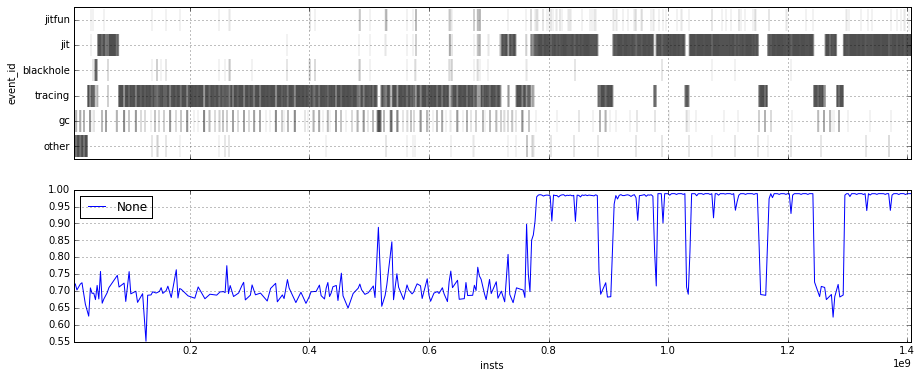

In [33]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_richards_mini_altjit_simple_no_ll_hooks_ff2/event_file_warmup.csv" )

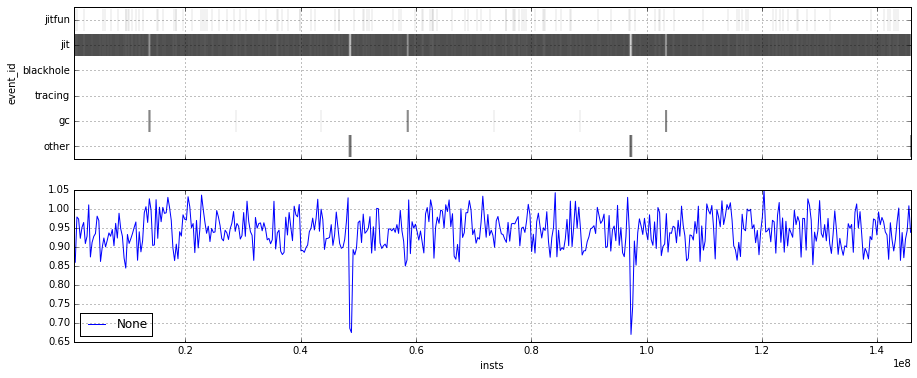

In [34]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_richards_mini_altjit_simple_ff2/event_file.csv" )

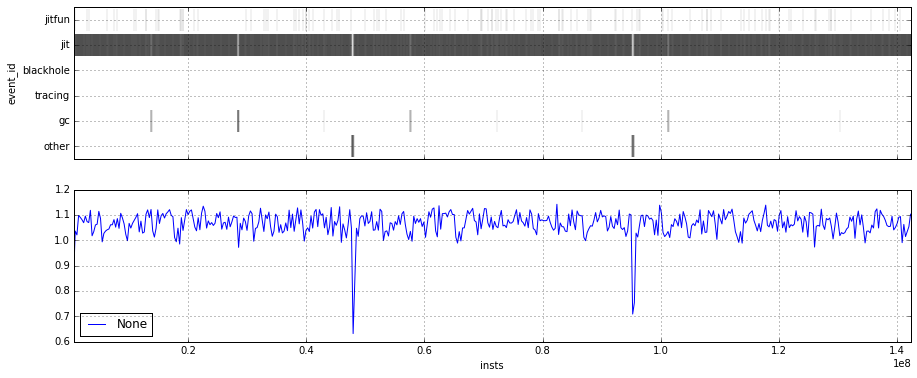

In [45]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/isatest_bm_richards_mini_altjit_simple_force_armv7_ff2_/event_file.csv" )

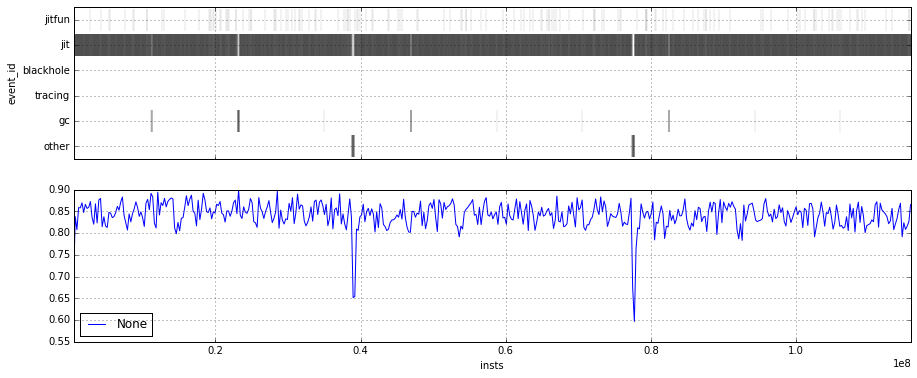

In [35]:
activity_plot_from_csv( "/home/graduate/bi45/gem5pyxcel/hooktest_bm_richards_mini_altjit_simple_no_ll_hooks_ff2/event_file.csv" )